In [3]:
import librosa 
import librosa.display
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tensorflow import keras 
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
path = Path.cwd()/'data'
new_path=Path.cwd()/'data_split'
answers = pd.read_csv('answers.csv')

In [7]:
whales = answers[answers['label']==1]
no_whales= answers[answers['label']==0]
no_whales_x_train, no_whales_x_val, no_whales_y_train, no_whales_y_val = train_test_split( no_whales[['image_path2']], no_whales.label, test_size=0.2, random_state=10)
whales_x_train, whales_x_val, whales_y_train, whales_y_val = train_test_split( whales[['image_path2','name']], whales.label, test_size=0.2, random_state=10)

In [263]:
# import subprocess

# for i, row in whales_x_train.iterrows():
#     subprocess.call(["cp", row[0], new_path/'training'/'whale' ])
    
# for i, row in whales_x_val.iterrows():
#     subprocess.call(["cp", row[0], new_path/'validation'/'whale'])    


In [265]:
# for i, row in no_whales_x_train.iterrows():
#     subprocess.call(["cp", row[0], new_path/'training'/'no_whale'])

In [266]:
# for i, row in no_whales_x_val.iterrows():
#     subprocess.call(["cp", row[0], new_path/'validation'/'no_whale'])

In [14]:
# datagen = ImageDataGenerator()
# images_directory = new_path
# cb_training = datagen.flow_from_directory(images_directory/'training', class_mode='binary')
# cb_validation = datagen.flow_from_directory(images_directory/'validation', class_mode='binary')


Found 23194 images belonging to 2 classes.
Found 6001 images belonging to 2 classes.


In [7]:
def import_data():
    datagen = ImageDataGenerator()
    new_path=Path.cwd()/'data_split'
    images_directory = new_path
    cb_training = datagen.flow_from_directory(images_directory/'training', class_mode='binary',target_size=(97,97) )
    cb_validation = datagen.flow_from_directory(images_directory/'validation', class_mode='binary',target_size=(97,97))
    return (cb_training, cb_validation)


def base_set_up(filename, patience=2):
    
    xx =compute_class_weight(class_weight='balanced',classes=np.unique(answers.label), y=answers.label)
    class_weight = dict(zip(np.unique(answers.label), xx))
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    earlystop = EarlyStopping(monitor='val_accuracy',verbose=1, patience=patience)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', save_best_only=True,save_weights_only=False, verbose=1)
    return (class_weight, METRICS, earlystop, checkpoint)

# CNN Adding a small layer 

In [8]:
cnn = None
keras.backend.clear_session()
filename = 'cnn_3_dense_3_dropout.h5'

cb_training, cb_validation = import_data()
class_weight, METRICS, earlystop, checkpoint = base_set_up(filename, 5)

cnn = Sequential()
cnn.add(InputLayer(input_shape=(97,97, 3)))
cnn.add(Conv2D(filters=5, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=40, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=50, kernel_size=3, activation='relu', padding='same'))
cnn.add(GlobalAveragePooling2D())



cnn.add(layers.Dense(100, activation='relu'))
cnn.add(layers.Dropout(.3))
cnn.add(layers.Dense(100, activation='relu'))
cnn.add(layers.Dropout(.3))
cnn.add(layers.Dense(100, activation='relu'))
cnn.add(layers.Dropout(.3))


cnn.add(layers.Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.00001)

cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=METRICS)

history = cnn.fit(cb_training, epochs=20,validation_data=cb_validation, class_weight = class_weight, callbacks=[earlystop, checkpoint])



Found 23194 images belonging to 2 classes.
Found 3047 images belonging to 2 classes.


2022-03-23 02:40:56.384625: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20


2022-03-23 02:40:56.832183: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


725/725 [==============================] - 72s 93ms/step - loss: 1.0525 - tp: 2854.0000 - fp: 10106.0000 - tn: 8272.0000 - fn: 1962.0000 - accuracy: 0.4797 - precision: 0.2202 - recall: 0.5926 - auc: 0.5200 - prc: 0.2164 - val_loss: 0.6014 - val_tp: 110.0000 - val_fp: 49.0000 - val_tn: 2295.0000 - val_fn: 593.0000 - val_accuracy: 0.7893 - val_precision: 0.6918 - val_recall: 0.1565 - val_auc: 0.8654 - val_prc: 0.6092

Epoch 00001: val_accuracy improved from -inf to 0.78930, saving model to cnn_3_dense_3_dropout.h5
Epoch 2/20
725/725 [==============================] - 52s 72ms/step - loss: 0.6397 - tp: 2746.0000 - fp: 6914.0000 - tn: 11464.0000 - fn: 2070.0000 - accuracy: 0.6127 - precision: 0.2843 - recall: 0.5702 - auc: 0.6346 - prc: 0.2950 - val_loss: 0.4854 - val_tp: 559.0000 - val_fp: 436.0000 - val_tn: 1908.0000 - val_fn: 144.0000 - val_accuracy: 0.8096 - val_precision: 0.5618 - val_recall: 0.7952 - val_auc: 0.8821 - val_prc: 0.6581

Epoch 00002: val_accuracy improved from 0.78930 

725/725 [==============================] - 63s 87ms/step - loss: 0.3498 - tp: 4202.0000 - fp: 3214.0000 - tn: 15164.0000 - fn: 614.0000 - accuracy: 0.8350 - precision: 0.5666 - recall: 0.8725 - auc: 0.9140 - prc: 0.6978 - val_loss: 0.2314 - val_tp: 639.0000 - val_fp: 229.0000 - val_tn: 2115.0000 - val_fn: 64.0000 - val_accuracy: 0.9038 - val_precision: 0.7362 - val_recall: 0.9090 - val_auc: 0.9632 - val_prc: 0.8767

Epoch 00017: val_accuracy improved from 0.89301 to 0.90384, saving model to cnn_3_dense_3_dropout.h5
Epoch 18/20
725/725 [==============================] - 63s 87ms/step - loss: 0.3412 - tp: 4206.0000 - fp: 3099.0000 - tn: 15279.0000 - fn: 610.0000 - accuracy: 0.8401 - precision: 0.5758 - recall: 0.8733 - auc: 0.9184 - prc: 0.7083 - val_loss: 0.2678 - val_tp: 659.0000 - val_fp: 326.0000 - val_tn: 2018.0000 - val_fn: 44.0000 - val_accuracy: 0.8786 - val_precision: 0.6690 - val_recall: 0.9374 - val_auc: 0.9643 - val_prc: 0.8799

Epoch 00018: val_accuracy did not improve from 

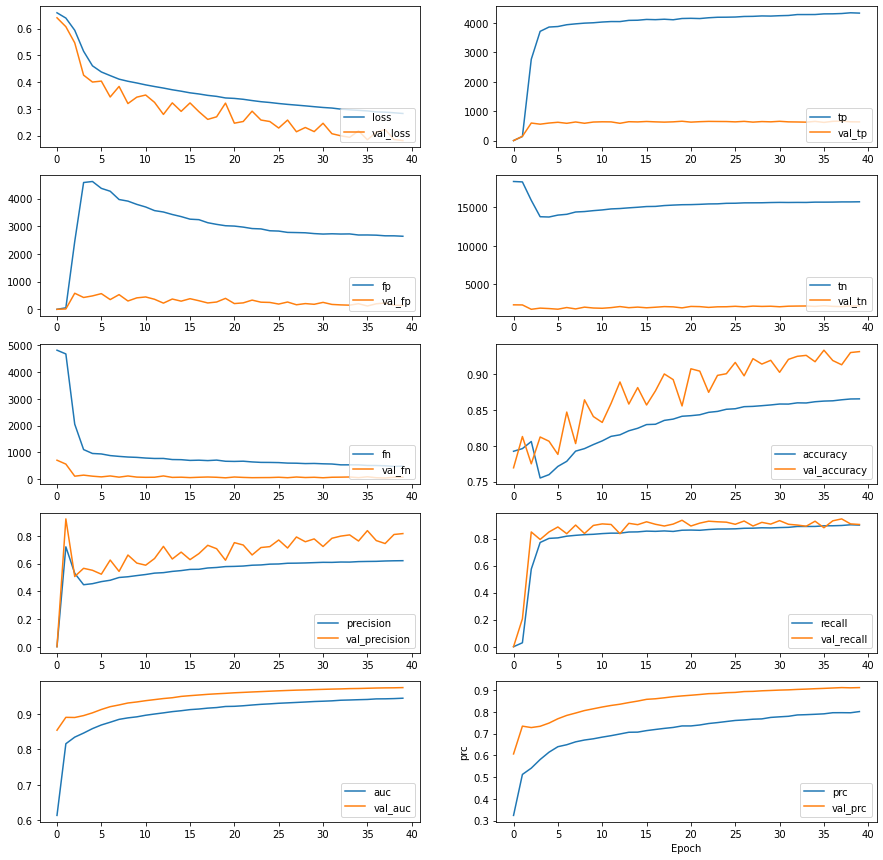

In [15]:
hist = history.history
all_keys = list(hist.keys())

fig, axes = plt.subplots(5,2, figsize=(15,15))
for i,ax in enumerate(axes.flatten()):
        key = all_keys[i]
        val_key = 'val_'+key
        ax.plot(hist[key], label=key)
        ax.plot(hist[val_key]+hist2[val_key], label = val_key)
        plt.xlabel('Epoch')
        plt.ylabel(key)
        ax.legend(loc='lower right')

# Analysis 

Val Recall is dropping like a rock - thats bad.  
Val loss is slowly growing.  
Val accuracy is leveled off - we're not seeing a drop, but with the other values getting worse, and our misbalanced sets, Im ok with that.  
Val auc is dropping off. 

## Are we overfitting? 
Yes. 

## What shall we do next? 
That recall is concerning. Lets inspect the confusion matrix 